## Ordinal Regression using statsmodels
### https://analyticsindiamag.com/a-complete-tutorial-on-ordinal-regression-in-python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline as IMBPipeline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Data Import
df = pd.read_csv('../../../../data/diamonds.csv')
df.head(10)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [5]:
df.cut.unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

## Balancing the dataset

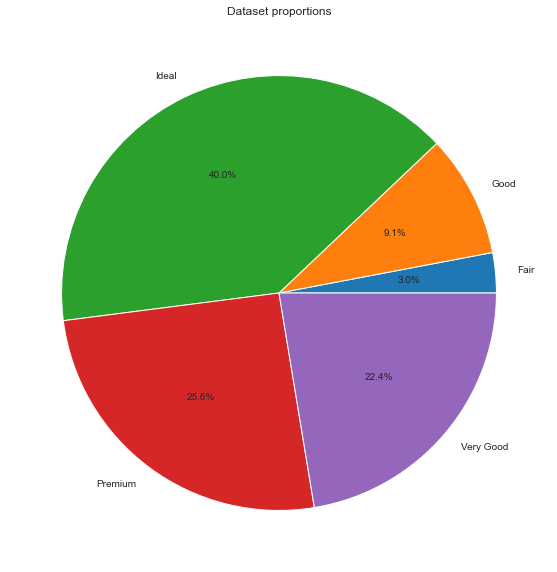

In [6]:
# Notice how unbalanced is the dataset
labels, counts = np.unique(df.cut, return_counts=True)

plt.figure(figsize=(10, 10))
plt.pie(counts, autopct='%1.1f%%', labels=labels)
plt.title('Dataset proportions')
plt.show()

We observe that data is not balanced, we need to balalnce the data

In [7]:
# calculate the volume of the diamonds
df['volume'] = df['x']*df['y']*df['z']
df.drop(['x','y','z'],axis=1,inplace=True)
x = df[['carat','depth', 'table','price','volume']]
y = df[['cut']]

In [28]:
# Over-Sampling
over = SMOTE()
# Under-Sampling
under = EditedNearestNeighbours()

imb_pipeline = IMBPipeline([('o', over), ('u', under)])
# transform the dataset
x_sm, y_sm = imb_pipeline.fit_resample(x, y)

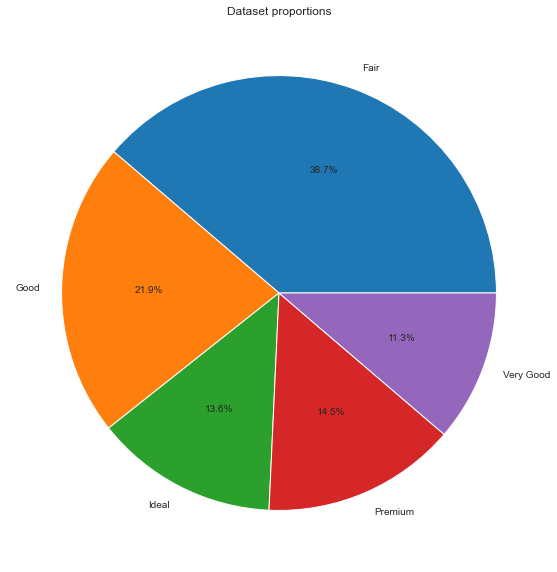

In [29]:
labels, counts = np.unique(y_sm, return_counts=True)

plt.figure(figsize=(10, 10))
plt.pie(counts, autopct='%1.1f%%', labels=labels)
plt.title('Dataset proportions')
plt.show()

## Vsualize Data

Text(0.5, 1.0, 'Distribution by Volume')

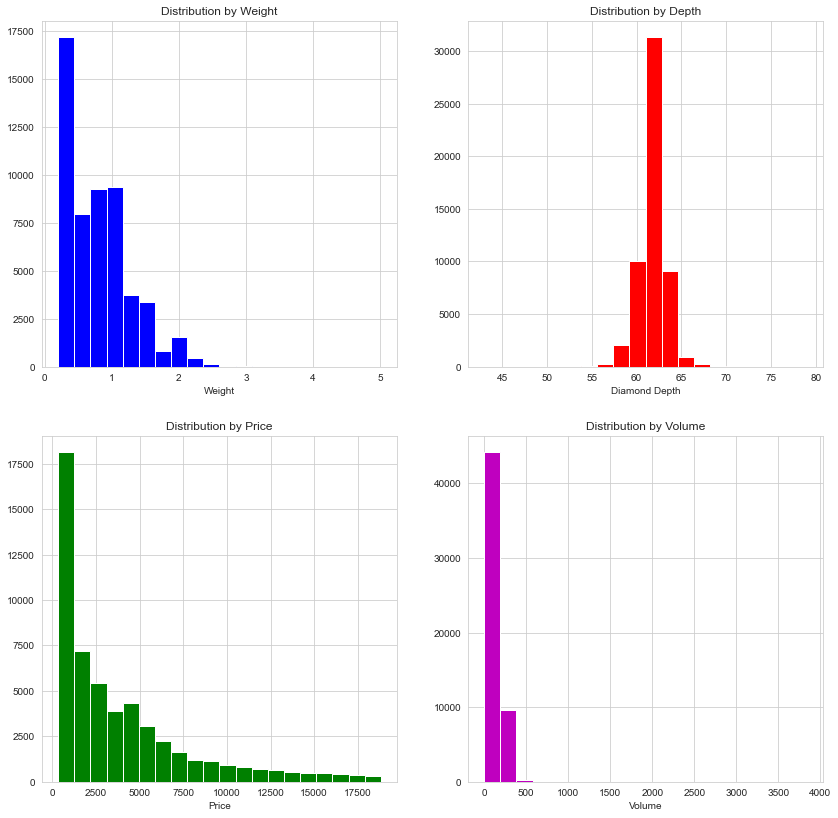

In [10]:
plt.figure(figsize=[14,14])

plt.subplot(221)
plt.hist(df['carat'],bins=20,color='b')
plt.xlabel('Weight')
plt.title('Distribution by Weight')

plt.subplot(222)
plt.hist(df['depth'],bins=20,color='r')
plt.xlabel('Diamond Depth')
plt.title('Distribution by Depth')

plt.subplot(223)
plt.hist(df['price'],bins=20,color='g')
plt.xlabel('Price')
plt.title('Distribution by Price')

plt.subplot(224)
plt.hist(df['volume'],bins=20,color='m')
plt.xlabel('Volume')
plt.title('Distribution by Volume')

## Data preprocessing

In [11]:
# convert the target variable into a categorical ordered form
cut_type = CategoricalDtype(categories=['Fair', 'Good', 'Ideal', 'Very Good', 'Premium'], ordered=True)
y_sm["cut"] = y_sm["cut"].astype(cut_type)
y_sm['cut'].dtype

CategoricalDtype(categories=['Fair', 'Good', 'Ideal', 'Very Good', 'Premium'], ordered=True)

Here we can see that now the values under the cut variable are in a categorical ordered form

## Ordered probit model

In [12]:
# Define ordered probit model taking the cut variable as our target and volume, price, and carat as independent variables.
mod_probit = OrderedModel(y_sm['cut'],
                        x_sm[['carat','depth', 'table','price','volume']],
                        distr='probit')

res_probit = mod_probit.fit(method='bfgs')
res_probit.summary()

         Current function value: 1.253283
         Iterations: 48
         Function evaluations: 113
         Gradient evaluations: 102


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                    cut   Log-Likelihood:                -69857.
Model:                   OrderedModel   AIC:                         1.397e+05
Method:            Maximum Likelihood   BIC:                         1.398e+05
Date:                Thu, 06 Apr 2023                                         
Time:                        01:43:42                                         
No. Observations:               55739                                         
Df Residuals:                   55730                                         
Df Model:                           9                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
carat                -4.9240      0.189    -26.059      0.000      -5.294      -4.554
depth                -0.2729      0.003    -94.380      0.000      -0.279      -0.267
table                -0.1116      0.002    -51.063      0.000      -0.116      -0.107
price                 0.0002   4.17e-06     57.397      0.000       0.000       0.000
volume                0.0167      0.001     14.255      0.000       0.014       0.019
Fair/Good           -24.9663      0.268    -93.054      0.000     -25.492     -24.440
Good/Ideal           -0.1782      0.008    -22.023      0.000      -0.194      -0.162
Ideal/Very Good      -0.7072      0.011    -67.148      0.000      -0.728      -0.687
Very Good/Premium    -0.8008      0.012    -67.577      0.000      -0.824      -0.778
=====================================================================================
"""

In [13]:
# Prediction
predicted = res_probit.model.predict(res_probit.params, exog=x_sm[['carat','depth', 'table','price','volume']])
predicted

array([[5.00847627e-01, 2.98398422e-01, 1.09312657e-01, 5.39767188e-02,
        3.74645757e-02],
       [1.44837915e-01, 2.67308718e-01, 1.94647899e-01, 1.57424519e-01,
        2.35780948e-01],
       [9.42053393e-01, 4.99496376e-02, 6.14334897e-03, 1.45104873e-03,
        4.02571895e-04],
       ...,
       [2.83296402e-01, 3.20709571e-01, 1.71388360e-01, 1.10638390e-01,
        1.13967277e-01],
       [7.13172979e-02, 1.93277458e-01, 1.81219792e-01, 1.76939830e-01,
        3.77245623e-01],
       [2.42941092e-01, 3.12702599e-01, 1.80967937e-01, 1.23739877e-01,
        1.39648495e-01]])

In [14]:
y_pred = predicted.argmax(axis=1)
y_pred = pd.DataFrame(y_pred,columns=['y'])
cut_map = {0:'Fair', 1:'Good', 2:'Ideal', 3:'Very Good', 4:'Premium'}
y_pred['y'] = y_pred['y'].map(cut_map)

In [15]:
y_pred

,y
0,Fair
1,Good
2,Fair
3,Fair
4,Fair
...,...
55734,Premium
55735,Good
55736,Good
55737,Premium


## Model Testing

In [16]:
print(f'The model accuracy is: {np.round(accuracy_score(y_sm.cut, y_pred), decimals=3)*100}%')

The model accuracy is: 46.9%


In [17]:
print(f'The model f1 score is: {np.round(f1_score(y_sm.cut, y_pred, average="""weighted"""), decimals=3)*100}%')

The model f1 score is: 40.9%


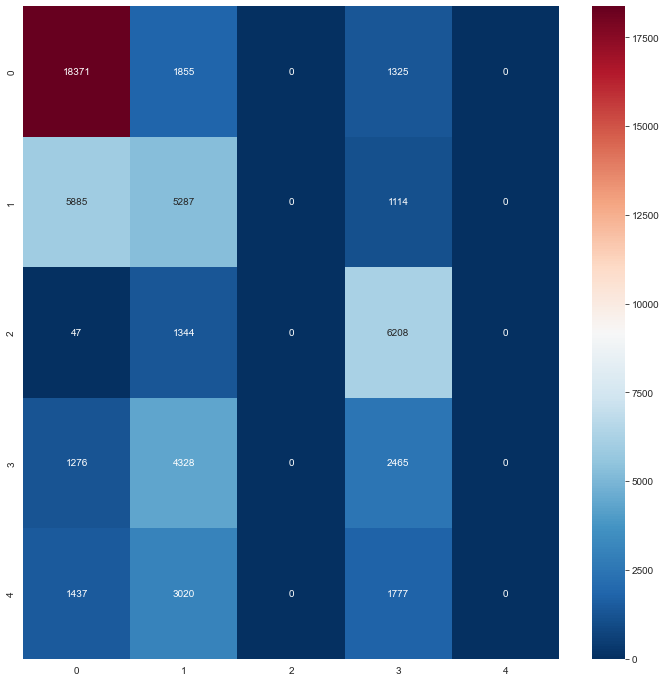

In [18]:
cm = confusion_matrix(y_sm.cut, y_pred)
plt.figure(figsize=(12, 12))
cmap = sns.color_palette("Oranges",12)
sns.heatmap(data=cm, cmap="RdBu_r", fmt='g', annot=True)
plt.show()

## Ordered logit regression

In [19]:
# Define ordered probit model taking the cut variable as our target and volume, price, and carat as independent variables.
mod_logit = OrderedModel(y_sm['cut'],
                          x_sm[['carat','depth', 'table','price','volume']],
                          distr='logit')

res_logit = mod_logit.fit(method='bfgs')
res_logit.summary()

         Current function value: 1.246699
         Iterations: 34
         Function evaluations: 101
         Gradient evaluations: 93


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                    cut   Log-Likelihood:                -69490.
Model:                   OrderedModel   AIC:                         1.390e+05
Method:            Maximum Likelihood   BIC:                         1.391e+05
Date:                Thu, 06 Apr 2023                                         
Time:                        01:44:16                                         
No. Observations:               55739                                         
Df Residuals:                   55730                                         
Df Model:                           9                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
carat               -25.2682        nan        nan        nan         nan         nan
depth                -0.3549        nan        nan        nan         nan         nan
table                -0.1088        nan        nan        nan         nan         nan
price                 0.0004        nan        nan        nan         nan         nan
volume                0.1322        nan        nan        nan         nan         nan
Fair/Good           -30.9946        nan        nan        nan         nan         nan
Good/Ideal            0.3781        nan        nan        nan         nan         nan
Ideal/Very Good      -0.1690        nan        nan        nan         nan         nan
Very Good/Premium    -0.2293        nan        nan        nan         nan         nan
=====================================================================================
"""

In [20]:
# Prediction
predicted = res_logit.model.predict(res_logit.params, exog=x_sm[['carat','depth', 'table','price','volume']])
predicted

array([[0.34065337, 0.34913279, 0.14824202, 0.08170595, 0.08026586],
       [0.0817994 , 0.19535073, 0.19434766, 0.19245922, 0.33604299],
       [0.90440382, 0.07162516, 0.01352627, 0.00570145, 0.0047433 ],
       ...,
       [0.23332433, 0.33373649, 0.18588376, 0.11801724, 0.12903818],
       [0.08025233, 0.19275459, 0.19331659, 0.19298195, 0.34069453],
       [0.21294846, 0.32504321, 0.19243133, 0.12673469, 0.1428423 ]])

In [21]:
y_pred = predicted.argmax(axis=1)
y_pred = pd.DataFrame(y_pred,columns=['y'])
cut_map = {0:'Fair', 1:'Good', 2:'Ideal', 3:'Very Good', 4:'Premium'}
y_pred['y'] = y_pred['y'].map(cut_map)

In [22]:
y_pred

,y
0,Good
1,Premium
2,Fair
3,Fair
4,Fair
...,...
55734,Premium
55735,Good
55736,Good
55737,Premium


## Model Testing

In [23]:
print(f'The model accuracy is: {np.round(accuracy_score(y_sm.cut, y_pred), decimals=3)*100}%')

The model accuracy is: 47.199999999999996%


In [24]:
print(f'The model f1 score is: {np.round(f1_score(y_sm.cut, y_pred, average="""weighted"""), decimals=3)*100}%')

The model f1 score is: 41.9%


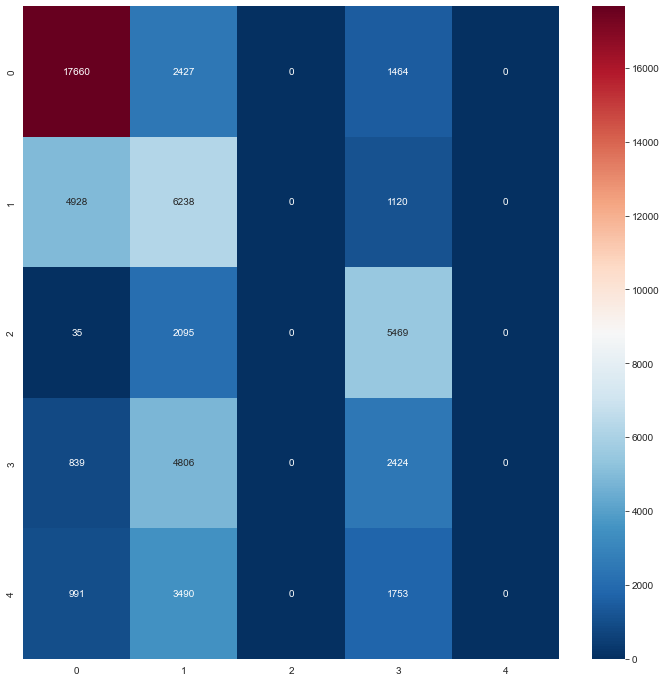

In [25]:
cm = confusion_matrix(y_sm.cut, y_pred)
plt.figure(figsize=(12, 12))
cmap = sns.color_palette("Oranges",12)
sns.heatmap(data=cm, cmap="RdBu_r", fmt='g', annot=True)
plt.show()